Import Dependencies

In [1]:
import os
import time
import sys
import numpy as np
%pip install opencv-python
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
from core.raft import RAFT
from core.utils import flow_viz
from core.utils.utils import InputPadder

Note: you may need to restart the kernel to use updated packages.


C:\Users\Alex\AppData\Local\Temp\ipykernel_16512\3709459852.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print("Is torch.cuda Available? ", torch.cuda.is_available())
print("Device Count: ",torch.cuda.device_count())
print("Current Device: ", torch.cuda.device(torch.cuda.current_device()))
print("Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

Is torch.cuda Available?  True
Device Count:  1
Current Device:  <torch.cuda.device object at 0x0000022A17D65190>
Device Name:  NVIDIA GeForce GTX 970


Add RAFT/core to path

In [3]:
sys.path.append('RAFT/core')

Define Helper Functions

In [4]:
def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(
        weights_path, map_location=torch.device("cuda")) # Change to cuda if available
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda") # Change to cuda if available
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel', iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
            flow_low, flow_up = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_low, flow_up

        else:
            flow_iters = model(frame1, frame2, iters=iters, flow_init=flow_init, upsample=upsample, test_mode=test_mode)
            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1, 2, 0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
    def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
        self.model = model
        self.path = path
        self.small = small
        self.mixed_precision = mixed_precision
        self.alternate_corr = alternate_corr

    """ Sketchy hack to pretend to iterate through the class objects """

    def __iter__(self):
        return self

    def __next__(self):
        raise StopIteration

Load Model

In [5]:
model = load_model("models/raft-sintel.pth", args=Args())

Load Images

In [6]:
frame1 = cv2.imread('Test_Leaf_Obstacle_Frame_2.png')
frame2 = cv2.imread('Test_Leaf_Obstacle_Frame_3.png')

# Convert images to rgb color space
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Resize the second image to match the dimensions of the first image
height, width, channels = frame2.shape
frame1 = cv2.resize(frame1, (width, height))

Run RAFT Model on Images

In [7]:
time1 = time.perf_counter()
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)
time2 = time.perf_counter()
print("Inference Time: ", time2 - time1)
print("Flow Iterations List Size", len(flow_iters))

c:\Users\Alex\anaconda3\envs\indoorfarming\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Inference Time:  1.8358146999962628
Flow Iterations List Size 20


Visualizing Model Inference for Optical Flow from Frame 1 to Frame 2

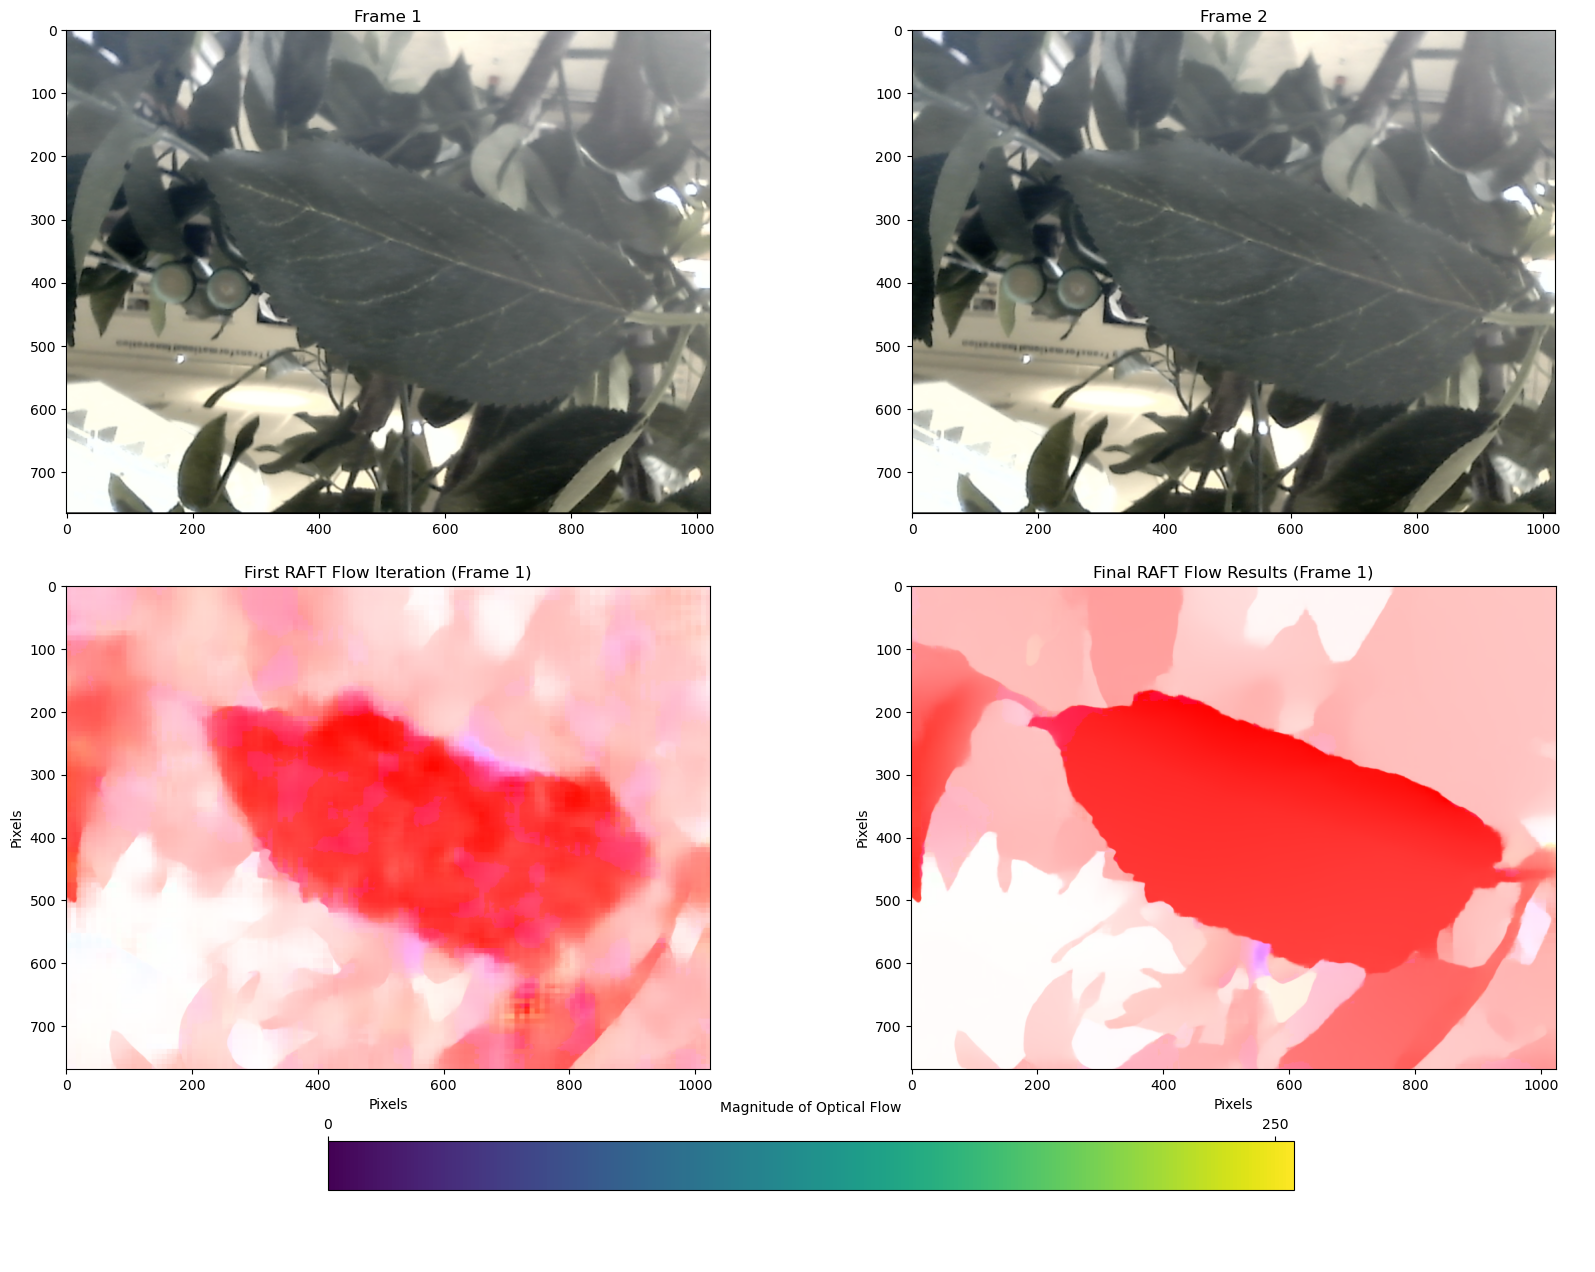

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), gridspec_kw={'height_ratios': [4, 4, 1]})
axes[0, 0].imshow(frame1)
axes[0, 0].set_title("Frame 1")
axes[0, 1].imshow(frame2)
axes[0, 1].set_title("Frame 2")

first_flow_image = axes[1, 0].imshow(get_viz(flow_iters[0]))
axes[1, 0].set_title('First RAFT Flow Iteration (Frame 1)')
axes[1, 0].set_xlabel("Pixels"); axes[1, 0].set_ylabel("Pixels")
final_flow_image = axes[1, 1].imshow(get_viz(flow_iters[-1]))
axes[1, 1].set_title('Final RAFT Flow Results (Frame 1)')
axes[1, 1].set_xlabel("Pixels"); axes[1, 1].set_ylabel("Pixels")

# Add color bars
axes[2, 0].axis('off')
axes[2, 1].axis('off')
cbar0 = fig.colorbar(first_flow_image, ax=axes[2, :], fraction=0.4, pad=0.04, location="top")
cbar0.set_label('Magnitude of Optical Flow')
cbar0.set_ticks([0, 250])

# Adjust layout to ensure all plots and color bars are visible
# plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

Final Iteration Flow Analysis

In [10]:
final_flow = flow_iters[-1]
flow_x_matrix = final_flow[0, 0]  # Horizontal displacement component in pixels
flow_y_matrix = final_flow[0, 1]  # Vertical displacement component in pixels

# Compute the magnitude of flow
flow_magnitude = torch.sqrt(flow_x_matrix**2 + flow_y_matrix**2)

flow_x_matrix = flow_x_matrix.cpu().numpy() # Tensor to numpy array can only be done on CPU
flow_y_matrix = flow_y_matrix.cpu().numpy()
flow_magnitude = flow_magnitude.cpu().numpy()
print(flow_x_matrix[446, 885])

19.196808


Create Matrix of Pixel Coordinates

In [12]:
# Get the shape of the image
height, width, channels = final_flow_image.get_array().shape

# Create arrays representing the x and y coordinates of pixels
x_coords = np.tile(np.arange(width), height)
y_coords = np.repeat(np.arange(height), width)

# Reshape x_coords and y_coords to match the shape of the image
x_coords = x_coords.reshape(height, width)
y_coords = y_coords.reshape(height, width)

# Stack x_coords and y_coords to create the matrix of pixels
pixel_matrix = np.dstack((x_coords, y_coords))
x_pixel_matrix = pixel_matrix[:, :, 0]
y_pixel_matrix = pixel_matrix[:, :, 1]

X, Y, Z Location of Each Pixel in Frame 1 with Respect to Tool Frame

In [15]:
# Declare stereo related variables
baseline_x = 0.0025
tilt = np.radians(1.5) 
focal_length = 891.77161 
cam_x_offset = 0.000 
cam_y_offset = 0.000
pitch_angle = np.radians(0) 
image_center_x = final_flow[0][0].shape[1] / 2
image_center_y = final_flow[0][0].shape[0] / 2 

# Calculations
world_conversion = baseline_x * np.cos(tilt) / flow_x_matrix # Calculating pixel to world conversion
x_offsets = cam_x_offset - baseline_x # Including camera offset from center of gripper (if using a horizontal offset)
x_translation_matrix = world_conversion * (-1 * x_pixel_matrix + image_center_x) # Calculating 

y_offsets = cam_y_offset
pitch_offset = -((baseline_x * focal_length) / flow_x_matrix) * np.sin(pitch_angle) # Essentially using z-depth to find pitch offset
y_translation_matrix = -world_conversion * (image_center_y - y_pixel_matrix) # Negated because camera is flipped upside down to match camera axes

z_depth_matrix = ((baseline_x * focal_length) / flow_x_matrix)
x_coordinates_matrix = x_offsets - x_translation_matrix
y_coordinates_matrix = pitch_offset + y_offsets + y_translation_matrix
print(z_depth_matrix[330, 330])

0.11369797
